# Importing file dependencies for the code.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import astropy_mpl_style
from glob import glob
import os
import numpy as np
import scipy as sp
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import optimize
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore", module='astropy.wcs.wcs')
from astropy.timeseries import LombScargle
from scipy import stats

# Setting defaults for the plots.

In [3]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['errorbar.capsize'] = 3
opts = {'mec':'k', 'mew': 0.5, 'lw': 1}

# Importing the fits files.

In [4]:
#importing the data from the base directory, and adding the names to a variable with glob
datadir = '/home/taterz/V453Cyg_data/'
fnames = glob(os.path.join(datadir, '*.fits'))

data_month1 = fits.getdata(fnames[0], ext=1)
data_month2 = fits.getdata(fnames[1], ext=1)

# get quality flag of 0 for each set of data
flag_check1 = data_month1['QUALITY'] == 0
lc_data_month1 = data_month1[flag_check1]

flag_check2 = data_month2['QUALITY'] == 0
lc_data_month2 = data_month2[flag_check2]

Defining some functions to be used later. Since the program will be using multiple iterations, it just makes sense to try and use a function to do it multiple times.

In [334]:
def remove_eclipse(flux, eclp_flux): 
    """Removes the eclipsing dips from the flux. Uses fits file flux data and a number 
        for the estimated eclipse flux count. 
    
    'flux' - filtered fits data array containing flux values
    'eclp_flux' - value for the eclipse flux
    
    'flux_eclp_rm - further filtered fits data array holding removed eclipse data'
    """

    #applies a truth check to filter out values above the value given from input
    flag_check_flux = flux['SAP_FLUX'] >= eclp_flux
    flux_eclp_rm = flux[flag_check_flux]
    
    
    return flux_eclp_rm

def lomb_scargle(times, flux):
    """Takes the time list and flux to determine the most probable frequency.
        Returns value for the frequencies, power ratings, and max period.
    
    'times' - list holding the time measurements
    'flux' - list holding the flux measurements
    """
    freq, power = LombScargle(times, flux).autopower()
    max_period = 1 / freq[np.argmax(power)]
    
    return freq, power, max_period

def losc_plot(freq, power, period):
    """Simple function to plot the values for the lomb scargle output.
    
    'freq' - list holding the frequencies 
    'power' - list holding the relative power values
    'period' - value for the maximum power frequency corresponding to the period
    
    """
    
    plt.plot(freq, power, 'r', lw=5)
    plt.ylabel('Power')
    plt.xlabel('Frequency (1/day)')
    print("The max period is:", '%.5f'%period, "days.")
    
def phase_fold_plot(times, flux, period):
    """Creates a plot of the phase folded flux based on the max period.
    
    'times' - array holding the time values
    'flux' - array holding the flux values
    'period' - value for the max period
    
    """
    #period = 3.89
    plt.plot(times % period, flux, 'r+');
    plt.xlabel('Phase')
    plt.ylabel('Normalized Counts')
    plt.grid();
    
def sine_func(x, a, b, c):
    return a * np.sin(b*x + c)

def curve_fitter(times, fluxes, period, func, amp):
    """Uses scipy's curve fit function to find a best fitted function based on
        user's input function.
        
    'times' - array holding the time values
    'fluxes' - array holding the flux values
    'period' - estimated period of the trend
    'func' - function to be fitted
    'amp' - initial estimate of the amplitude
    
    'params' - parameters for the fitted function
    'pcovar' - covariance of the parameters
    """
    fold_times = times % period
    params, pcovar = curve_fit(func, fold_times, fluxes, p0=[amp, period, 0])
    
    return params

def detrend(fold_times, fluxes, params, func):
    """Detrends the data based on the fitted function.
        
    'fold_times' - array holding the folded time values
    'fluxes' - array holding the flux values
    'func' - function to be fitted    
    'params' - parameters for the fitted function

    """
    #using the fitted model function to detrend the data
    y_fit = func(fold_times, params[0], params[1], params[2])
    flux_detrended = fluxes - y_fit
    
    return flux_detrended

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def fourthic(x, a, b, c):
    return a * x**4  + b * x**2 + c

Text(0, 0.5, 'Normalized Counts')

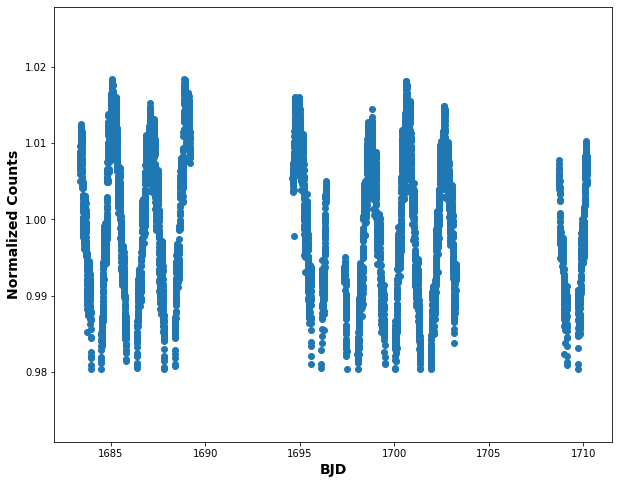

In [148]:
#removing the eclipsing data
fluxes_ecrm = remove_eclipse(lc_data_month1, 85500)

#using the removed data to store the flux and time values
fluxes_m1 = fluxes_ecrm['SAP_FLUX']
times_m1 = fluxes_ecrm['TIME']

#normalizing the function and plotting for a visual
norm = np.median(fluxes_m1)
fluxes_norm = fluxes_m1/norm
plt.scatter(times_m1, fluxes_norm)
plt.xlabel("BJD")
plt.ylabel("Normalized Counts")
#plt.xlim(1693,1696)

Text(0, 0.5, 'Power')

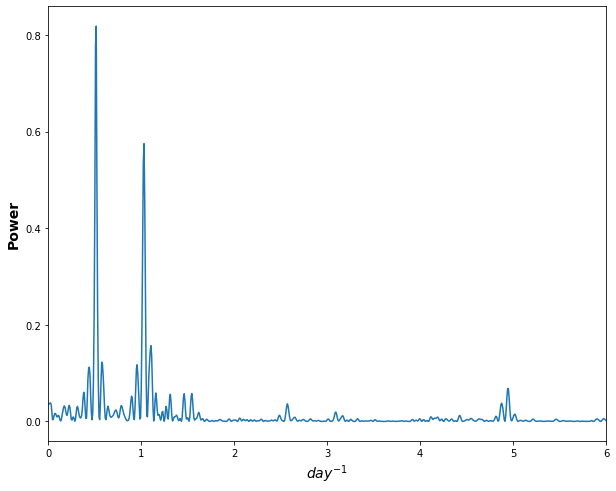

In [166]:
#finding the maximum frequency to determine the period using Lomb Scargle
freq1, pow1, period1 = lomb_scargle(times_m1, fluxes_norm)
#phase_fold_plot(times_m1, fluxes_norm, period1)
plt.plot(freq1, pow1)
plt.xlim(0,6)
plt.xlabel("$day^{-1}$")
plt.ylabel("Power")

Text(0.5, 0, 'Phase')

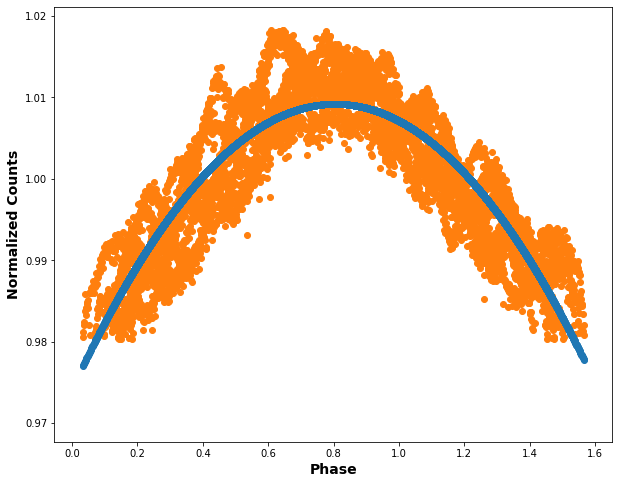

In [153]:
#phase folding the times according to the period we obtained earlier
fold_times = times_m1%period1

#using the curve fitting function to find the best fitting line parameters
params_maj_gone = curve_fitter(fold_times, fluxes_norm, period1, sine_func, 1)

#using those parameters in a fitted function
maj_gone = detrend(times_m1%period1, fluxes_norm, params_maj_gone, sine_func)
y_maj_gone = sine_func(fold_times, params_maj_gone[0], params_maj_gone[1], params_maj_gone[2])

#plotting function over the phase folded values
plt.scatter(fold_times, y_maj_gone, zorder=10)
plt.scatter(fold_times, fluxes_norm)
plt.ylabel("Normalized Counts")
plt.xlabel("Phase")

(1683, 1690)

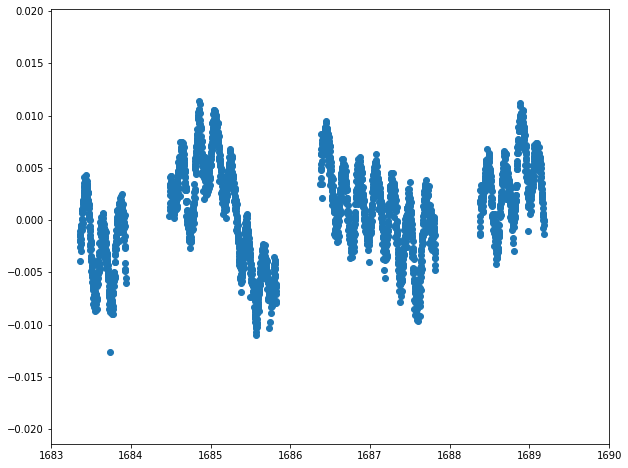

In [9]:
#simple plot just to see what the residual oscillating function looks like
#with the major oscillation removed

new_fluxes = fluxes_norm - y_maj_gone
plt.scatter(times_m1, new_fluxes)
plt.xlim(1683,1690)

Text(0, 0.5, 'Power')

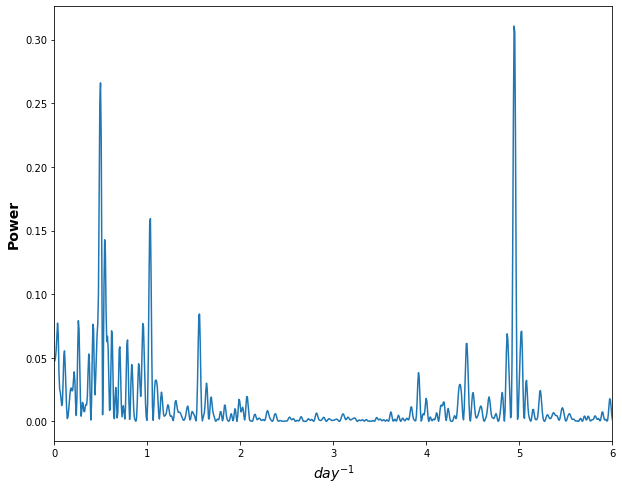

In [172]:
#once again using Lomb Scargle to determine the best period
freq2, pow2, period2 = lomb_scargle(times_m1, new_fluxes)
#phase_fold_plot(times_m1, new_fluxes, period2)
plt.plot(freq2, pow2)
plt.xlim(0,6)
plt.xlabel("$day^{-1}$")
plt.ylabel("Power")

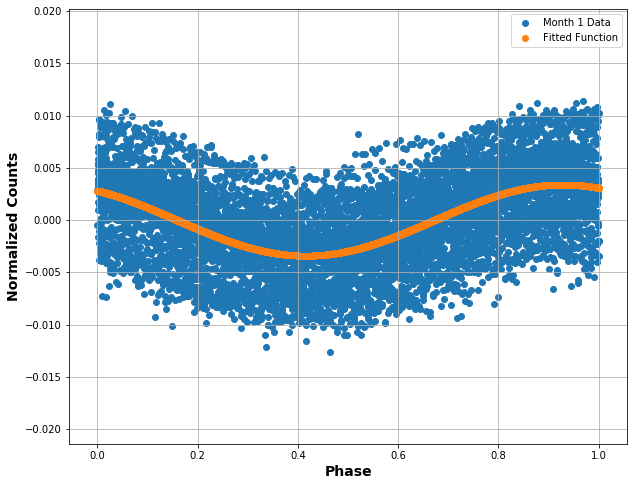

In [157]:
#phase folding and plotting to see what the function looks like
fold_times = times_m1 % period2
plt.scatter(fold_times/period2, new_fluxes, label='Month 1 Data')
plt.scatter(fold_times/period2, y_min, label='Fitted Function')
plt.xlabel("Phase")
plt.ylabel("Normalized Counts")
plt.grid()
plt.legend()

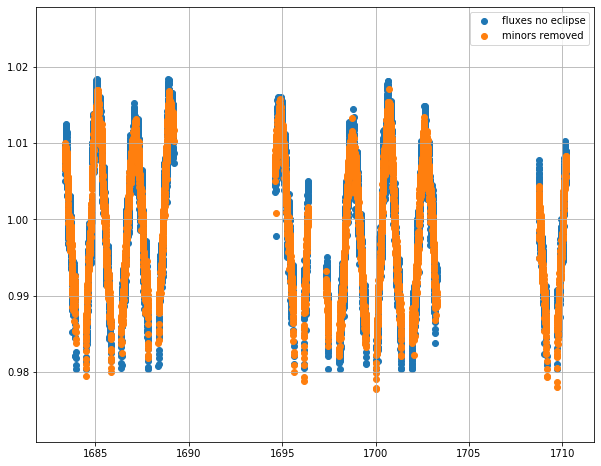

In [201]:
#same steps as before to determine the best fitting function
params_min_gone = curve_fitter(fold_times, new_fluxes, period2, sine_func, 0.005)
y_min = params_min_gone[0]*np.sin(params_min_gone[1]*fold_times + params_min_gone[2])
plt.scatter(times_m1, fluxes_norm, label='fluxes no eclipse')

#removing the minor humps attempt from the non-eclipse data
final_fluxes = fluxes_norm - y_min
plt.scatter(times_m1, final_fluxes, label='minors removed')
#plt.xlim(1693,1698)
#plt.ylim(0.95,1.02)
plt.grid()
plt.legend()
#plt.scatter(fold_times, y_min)

7581
7581


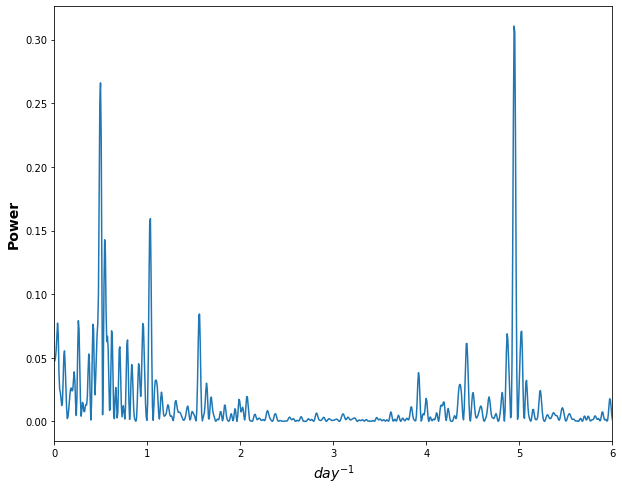

In [209]:
#once again using Lomb Scargle to determine the best period
test_fluxes = fluxes_norm - y_maj_gone #- y_min
freq3, pow3, period3 = lomb_scargle(times_m1, test_fluxes)
#phase_fold_plot(times_m1, new_fluxes, period2)
plt.plot(freq3, pow3)
plt.xlim(0,6)
plt.xlabel("$day^{-1}$")
plt.ylabel("Power")
print(len(y_maj_gone))
print(len(y_min))

Text(0, 0.5, 'Normalized Counts')

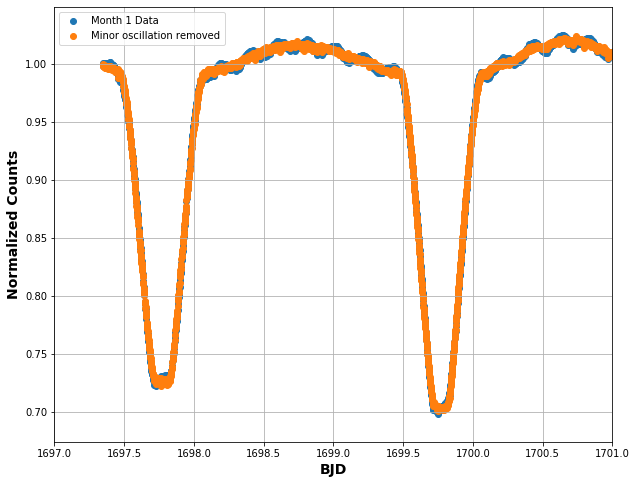

In [178]:
#with the minor oscillations determined, I remove it from the total data set
fluxes_all_m1 = lc_data_month1['SAP_FLUX']
errors_m1 = lc_data_month1['SAP_FLUX_ERR']
times_m1_full = lc_data_month1['TIME']

#normalizing the fluxes for the full month
fluxes_all_m1_norm = fluxes_all_m1/np.median(fluxes_all_m1)
errors_m1_norm = errors_m1/np.median(fluxes_all_m1)

#fold times now include the entire data set to ensure the array calculations align in size
fold_times_m1 = times_m1_full % period2
y_min = params_min_gone[0]*np.sin(params_min_gone[1]*(fold_times_m1) + params_min_gone[2])

final_full_fluxes = fluxes_all_m1_norm - y_min

plt.scatter(times_m1_full, fluxes_all_m1_norm, label='Month 1 Data')
plt.scatter(times_m1_full, final_full_fluxes, label='Minor oscillation removed')

plt.xlim(1697,1701)
#plt.ylim(.72,.75)
plt.grid()
plt.legend()
plt.xlabel("BJD")
plt.ylabel("Normalized Counts")

# Month 2 data

In [14]:
#a slight error from above, this time I define the full values early
times_m2_full = lc_data_month2['TIME']
fluxes_m2_full = lc_data_month2['SAP_FLUX']
errors_m2 = lc_data_month2['SAP_FLUX_ERR']
#plt.scatter(times_m2_full, fluxes_m2_full)
#plt.ylim(8.0e4, 8.9e4)

#removing the eclipse data from the second month's data
lc_m2_eclp_rm = remove_eclipse(lc_data_month2, 83000)

#storing the new data into variables to be detrended
fluxes_m2 = lc_m2_eclp_rm['SAP_FLUX']
times_m2 = lc_m2_eclp_rm['TIME']

#plt.scatter(times_m2, fluxes_m2)

In [15]:
norm_m2 = np.median(fluxes_m2)
fluxes_norm_m2 = fluxes_m2/norm_m2

#plt.scatter(times_m2, fluxes_norm_m2)
#plt.xlim(1725,1730)

#freq1_m2, pow1_m2, period1_m2 = lomb_scargle(times_m2, fluxes_norm_m2)
#phase_fold_plot(times_m2, fluxes_norm_m2, period1)
#print(period1, period1_m2)

Text(0, 0.5, 'Power')

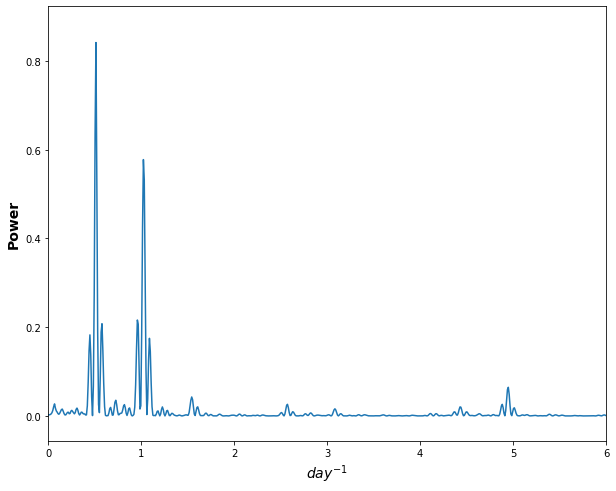

In [181]:
freq1_m2, pow1_m2, period1_m2 = lomb_scargle(times_m2, fluxes_norm_m2)
plt.plot(freq1_m2, pow1_m2)
plt.xlim(0,6)
plt.xlabel("$day^{-1}$")
plt.ylabel("Power")
#this result is a strange one, but the periods from the previous month came out the same as expected
#this 1/700th of a day result came up previously as well
#this is most likely from the collection time of image sampling every 2 minutes

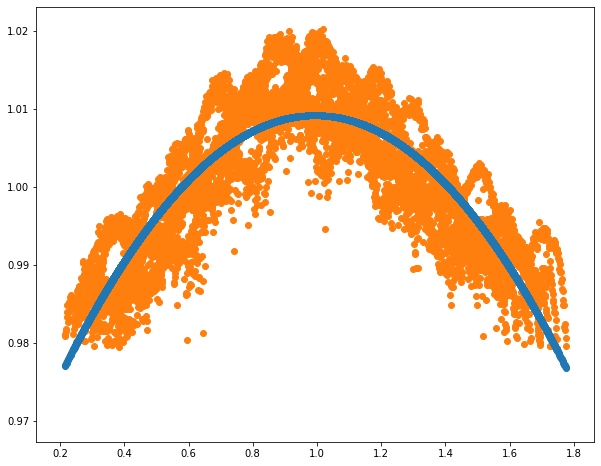

In [17]:
fold_times_m2 = times_m2%period1
params_maj_gone_m2 = curve_fitter(fold_times_m2, fluxes_norm_m2, period1, sine_func, 1)

maj_gone_m2 = detrend(times_m2%period1, fluxes_norm_m2, params_maj_gone_m2, sine_func)
y_maj_gone_m2 = sine_func(fold_times_m2, params_maj_gone_m2[0], params_maj_gone_m2[1], params_maj_gone_m2[2])


plt.scatter(fold_times_m2, y_maj_gone_m2, zorder=10)
plt.scatter(fold_times_m2, fluxes_norm_m2)

[ 0.00227105  0.0023639   0.00245234 ... -0.0027765  -0.0028391
 -0.00289639]


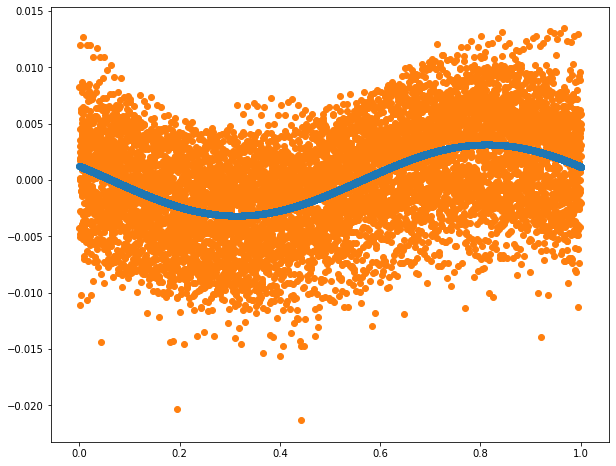

In [18]:
#removing the major hump from the folded data
new_fluxes_m2 = fluxes_norm_m2 - y_maj_gone_m2
#plt.scatter(times_m2, new_fluxes_m2)

fold_times_m2_min = times_m2%period2

#determining the wiggle parameters
params_min_gone_m2 = curve_fitter(fold_times_m2_min, new_fluxes_m2, period2, sine_func, 1)
y_min_m2 = sine_func(fold_times_m2_min, params_min_gone_m2[0], params_min_gone_m2[1], params_min_gone_m2[2])

#plotting the function and the data together
plt.scatter(fold_times_m2_min/period2, y_min_m2, zorder=10)
plt.scatter(fold_times_m2_min/period2, new_fluxes_m2)
print(y_min_m2)

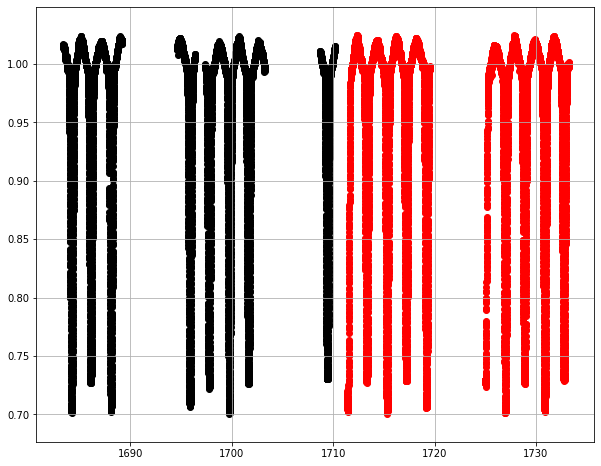

In [19]:
fluxes_all_m2 = lc_data_month2['SAP_FLUX']

#normalizing the fluxes for the full month
fluxes_all_m2_norm = fluxes_all_m2/np.median(fluxes_all_m2)
errors_m2_norm = errors_m2/np.median(fluxes_all_m2)

fold_times_m2 = (times_m2_full) % period2
y_min_fin_m2 = params_min_gone_m2[0]*np.sin(params_min_gone_m2[1]*(fold_times_m2) + params_min_gone_m2[2])

final_full_fluxes_m2 = fluxes_all_m2_norm - y_min_fin_m2

#plt.scatter(times_m2_full-2000, fluxes_all_m2_norm, color='blue', label='fluxes month2 eclipse')
plt.scatter(times_m2_full, final_full_fluxes_m2, color='red', label='fwiggle removed')
plt.scatter(times_m1_full, final_full_fluxes, color='black', label='fwiggle removed')

#plt.xlim(1713,1714)
#plt.ylim(.70,.75)
plt.grid()
#plt.legend()

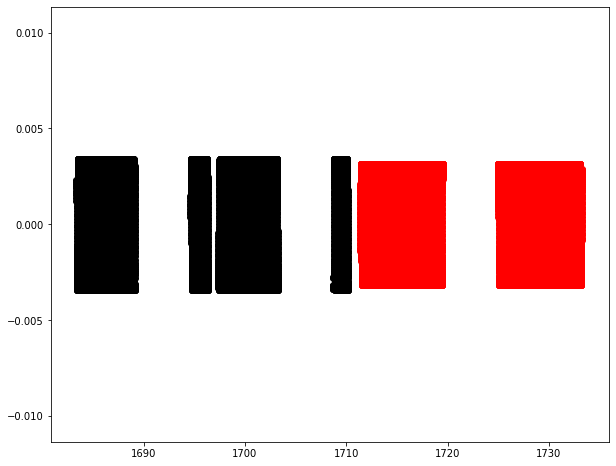

In [224]:
wigglem1 = final_full_fluxes - fluxes_all_m1_norm
wigglem2 = final_full_fluxes_m2 - fluxes_all_m2_norm

plt.scatter(times_m1_full, wigglem1, color='black', label='fwiggle removed')
plt.scatter(times_m2_full, wigglem2, color='red', label='fwiggle removed')
#plt.xlim(1682,1689)


4.942236676759209
4.943138342052693


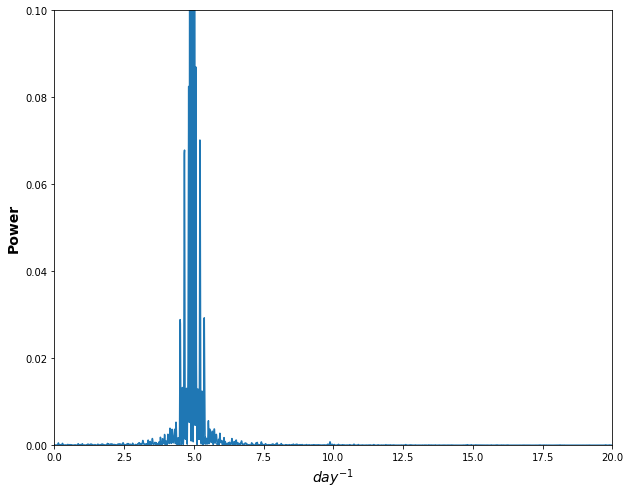

In [226]:
freq_w1, pow_w1, period_w1 = lomb_scargle(times_m1_full, wigglem1)
plt.plot(freq_w1, pow_w1)
plt.xlim(0,20)
plt.xlabel("$day^{-1}$")
plt.ylabel("Power")
print(1/period_w1)
plt.ylim(0,0.1)

4.9462641842570525


(0, 10)

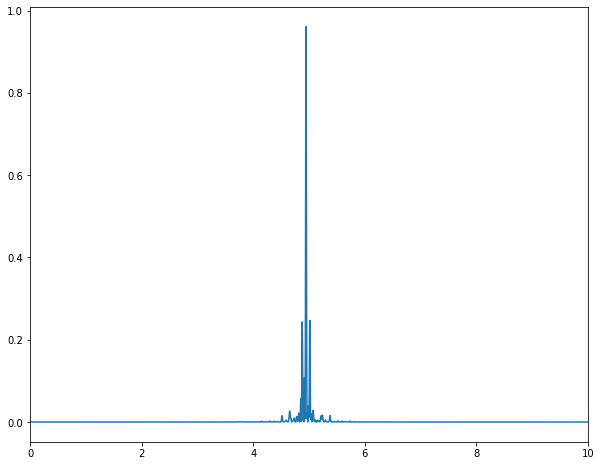

In [229]:
ultrawiggle = np.append(wigglem1, wigglem2)
ultratimes = np.append(times_m1_full, times_m2_full)
frequ, powu, periodu = lomb_scargle(ultratimes, ultrawiggle)
plt.plot(frequ, powu)
print(1/periodu)
plt.xlim(0,10)

4.944040007346176


(0, 0.1)

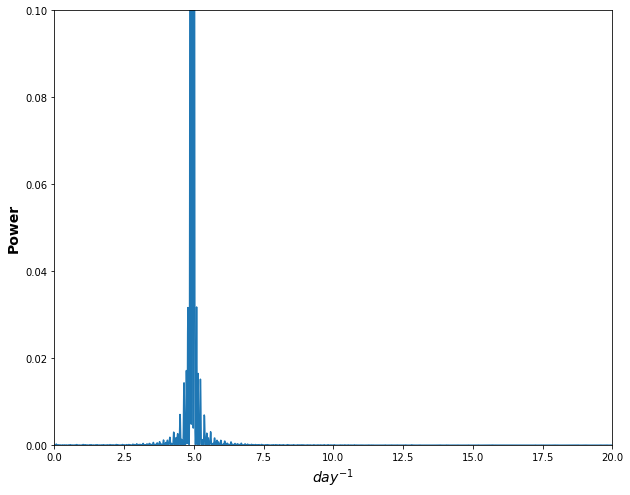

In [225]:
freq_w2, pow_w2, period_w2 = lomb_scargle(times_m2_full, wigglem2)
plt.plot(freq_w2, pow_w2)
plt.xlim(0,20)
plt.xlabel("$day^{-1}$")
plt.ylabel("Power")
print(1/period_w2)
plt.ylim(0,0.1)

In [20]:
m1e1 = [1684.23,1688.19,1695.855,1699.755]
m1e2 = [1686.5,1697.76,1701.65,1709.44]
m2e1 = [1711.44,1715.26,1719.21,1726.95,1730.87]
m2e2 = [1713.32,1717.22,1724.94,1728.85,1732.81]

Text(0, 0.5, 'Normalized Counts')

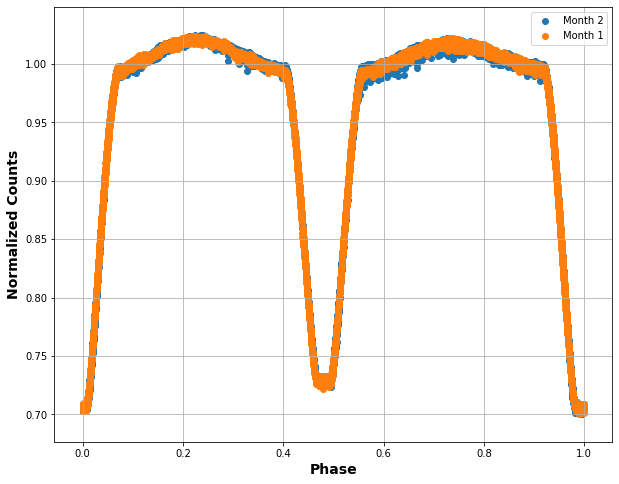

In [231]:
pmain = 3.8898128
#plt.scatter(((times_m1_full+1682.45) % pmain)/pmain, final_full_fluxes)
#plt.scatter(((times_m2_full+15711.48) % pmain)/pmain, final_full_fluxes_m2)
#plt.scatter(((times_m1_full+1682.55) % pmain)/pmain, final_full_fluxes)
#plt.scatter(((times_m1_full+1682.56) % pmain)/pmain, final_full_fluxes)

#plt.scatter(((times_m2_full+m2e1[0]) % pmain) / pmain, final_full_fluxes_m2, color='black')
#plt.scatter(((times_m1_full+m1e1[0]) % pmain) / pmain, final_full_fluxes, color='red')

plt.scatter(((times_m2_full-m1e1[0]) % pmain) / pmain, final_full_fluxes_m2, label='Month 2')
plt.scatter(((times_m1_full-m1e1[0]) % pmain) / pmain, final_full_fluxes, label='Month 1')
plt.grid()
#plt.xlim(-0.2,1.2)
#plt.ylim(.68,.72)
plt.xlabel("Phase")
plt.legend()
plt.ylabel("Normalized Counts")

## folded times, fluxes norm, errors norm

# orginal times + 2000, original normalized, errors norm

In [22]:
#plt.scatter(times_m1_full, final_full_fluxes)
#plt.ylim(0.6,.8)
#plt.xlim(1684, 1685)
#x = times_m1_full

#func = 7*(x-1684.21)**2 + 0.7
#func2 = 1*x**4 + 1*x**3 + 1*x**2 + 1*x + 0.7
#func3 = 590*(x-1684.21)**4 + 0.703

#plt.scatter(x, func)
#plt.scatter(x, func3, color='red')


In [23]:
import csv
fixed_timesm1 = times_m1_full + 2000
fixed_timesm2 = times_m2_full + 2000

shifted_times_m2 = ((times_m2_full-m1e1[0]) % pmain) / pmain
shifted_times_m1 = ((times_m1_full-m1e1[0]) % pmain) / pmain

with open('detrended_data_month1.txt', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(final_full_fluxes)):
        detrended_writer.writerow([fixed_timesm1[i], final_full_fluxes[i], errors_m1_norm[i]])

with open('detrended_data_month2.txt', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(final_full_fluxes_m2)):
        detrended_writer.writerow([fixed_timesm2[i], final_full_fluxes_m2[i], errors_m2_norm[i]])

with open('lightcurve_month2.txt', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(final_full_fluxes_m2)-1):
        detrended_writer.writerow([shifted_times_m2[i], final_full_fluxes_m2[i], errors_m2_norm[i]])

with open('lightcurve_month1.txt', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(final_full_fluxes)-1):
        detrended_writer.writerow([shifted_times_m1[i], final_full_fluxes[i], errors_m1_norm[i]])


In [143]:
def bin_data(times, fluxes):
    """
    Takes the time and flux data and bins them according to the input bin size.
    Returns an array containing the edges and bin means.
    
    times = array containing the time values
    fluxes = array containing the flux values
    
    bins = integer containing the total number of bins
    """
    bin_means, bin_edges, binnumber = sp.stats.binned_statistic(times, fluxes, bins=500)
    #print(len(bin_means), 'length of bin means')
    #print(len(bin_edges), 'length of bin edges')
    #print(len(binnumber), 'length of bin numbers')
    bin_std = sp.stats.binned_statistic(times, fluxes, bins=500, statistic='std')
    bin_count = sp.stats.binned_statistic(times, fluxes, bins=500, statistic='count')
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    return bin_edges, bin_means, bin_std, bin_count, bin_centers

In [128]:
#print(len(shifted_full_times))
#shifted_full_times[0] = 0
#shifted_full_times[-1] = 99
print(np.argmin(shifted_full_times))
shifted_full_times[18005] = 0
print(np.argmax(shifted_full_times), 'max')

shifted_full_times[7176] = 1

print(shifted_full_times[18005], shifted_full_times[7176])

18005
7176 max
0.0 1.0


Text(0, 0.5, 'Normalized Counts')

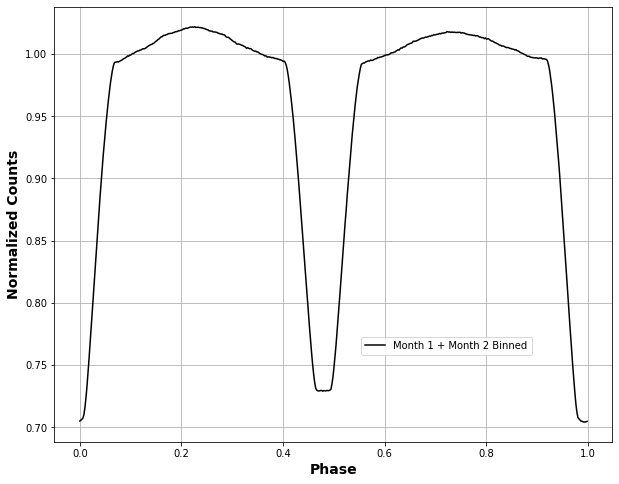

In [188]:
#using the function defined above to bin the data
shifted_full_times = np.append(shifted_times_m1, shifted_times_m2)
final_total_fluxes = np.append(final_full_fluxes, final_full_fluxes_m2)

shifted_full_times[18005] = 0
shifted_full_times[7176] = 1

bin_edges_full, bin_means_full, bins_std_full, bins_count_full, bin_centers = bin_data(shifted_full_times, final_total_fluxes)
#bin_edges_m2, bin_means_m2, bins_std_m2 = bin_data(shifted_times_m2, final_full_fluxes_m2, 500)

#plt.scatter(shifted_full_times, final_total_fluxes, label='Full Data', color='red')
plt.plot(bin_edges_full[:-1], bin_means_full, label='Month 1 + Month 2 Binned', color='black')

#plt.scatter(shifted_times_m2, final_full_fluxes_m2, label='M2 Data', color='black')
#plt.scatter(bin_edges_m2[:-1], bin_means_m2, label='Bin M2 data', color='green')

#plt.ylim(0.95,1.05)
#plt.xlim(0.2,0.6)
plt.grid()
plt.legend(loc=(0.55,0.2))

#print(np.sort(bins_std_full.binnumber)==1)
bin_unc = bins_std_full.statistic/np.sqrt(bins_count_full.statistic)
#print(bin_unc)
#print(bin_edges_full[:-1])
#print(len(bin_centers))
#print(len(bin_centers))
plt.xlabel("Phase")
plt.ylabel("Normalized Counts")

In [146]:
#bin_centers, bin_means_full, bin_unc

with open('binned_lightcurve.txt', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(bin_centers)):
        detrended_writer.writerow([bin_centers[i], bin_means_full[i], bin_unc[i]])

1684.2071253682425


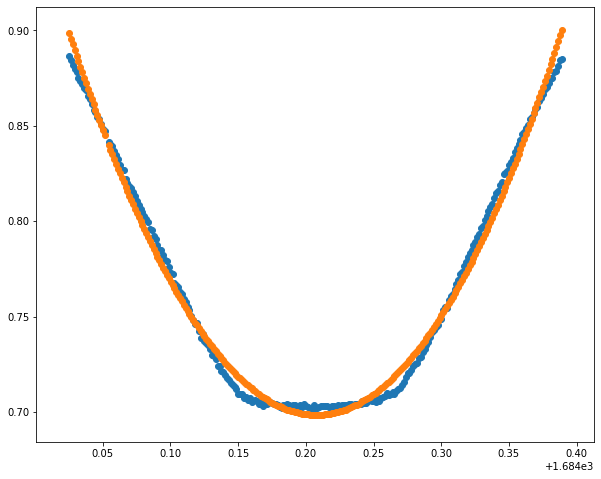

In [352]:
#plt.scatter(times_m2_full, final_full_fluxes_m2, color='red', label='fwiggle removed')
#plt.scatter(times_m1_full, final_full_fluxes, color='black', label='fwiggle removed')
#plt.xlim(1684,1684.5)
#plt.ylim(.69,.8)

m1 = times_m1_full, final_full_fluxes
ecl1 = (times_m1_full <= 1684.39) & (times_m1_full >= 1684.025)
#ecl2 = (final_full_fluxes <=)
m1_eclp1 = m1[0][ecl1], m1[1][ecl1]
plt.scatter(m1_eclp1[0], m1_eclp1[1])
params_ec, params_ec_cov = sp.optimize.curve_fit(six, m1_eclp1[0], m1_eclp1[1])

plt.scatter(m1_eclp1[0], params_ec[0]*m1_eclp1[0]**6 + params_ec[1]*m1_eclp1[0]**4 + params_ec[2]*m1_eclp1[0]**2 + params_ec[3])

#eclipse_time = -params_ec[1]/(2*params_ec[0])
ec1_func = params_ec[0]*m1_eclp1[0]**6 + params_ec[1]*m1_eclp1[0]**4 + params_ec[2]*m1_eclp1[0]**2 + params_ec[3]
print(m1_eclp1[0][130])

In [337]:
def six(x, a, b, c, d):
    return a * x**6  + b * x**4 + c * x**2 + d

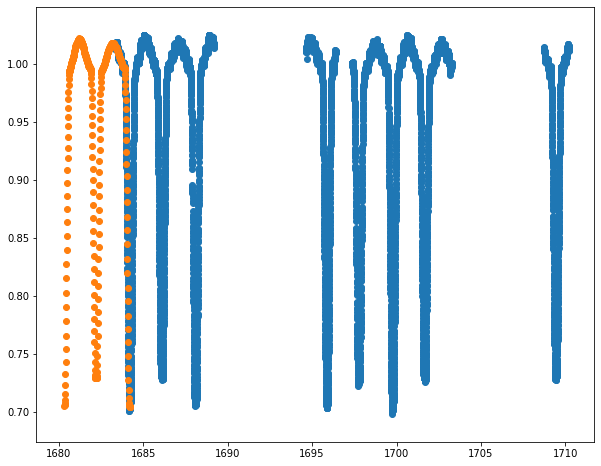

In [370]:
unfolded = bin_edges_full[:-1] * pmain + m1e1[0] - pmain
plt.scatter(times_m1_full, fluxes_all_m1_norm)
plt.scatter(unfolded, bin_means_full)
#plt.xlim(1685.8,1686.2)

#truewiggles = unfolded - fluxes_all_m1_norm

Text(0, 0.5, 'Normalized Counts')

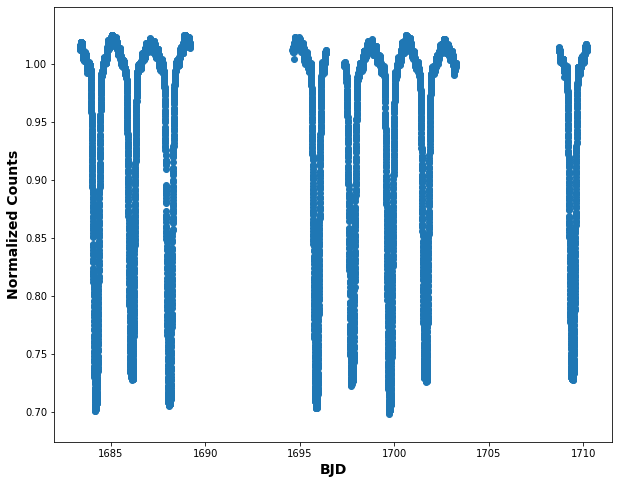

In [372]:
plt.scatter(times_m1_full, fluxes_all_m1_norm)
plt.xlabel('BJD')
plt.ylabel('Normalized Counts')

(1685, 1690)

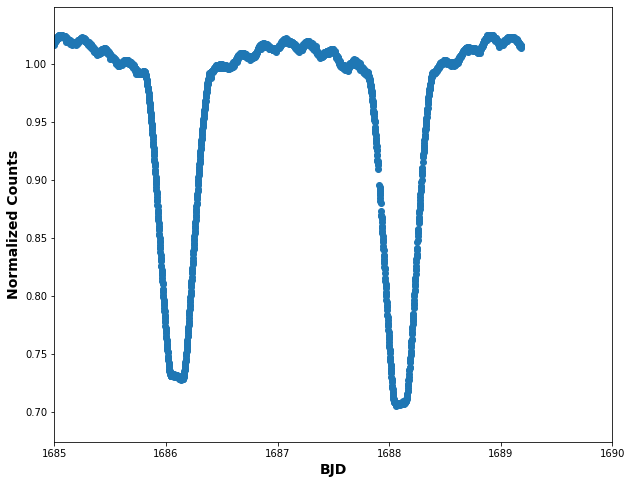

In [374]:
plt.scatter(times_m1_full, fluxes_all_m1_norm)
plt.xlabel('BJD')
plt.ylabel('Normalized Counts')
plt.xlim(1685,1690)